In [1]:
import requests
import json

In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

## Intro to ExEmPLAR

ExEmPLAR (https://www.exemplar.mml.unc.edu/) is an additional GUI-based tool that uses Cypher to explore the ROBOKOP KG. More information on the use of this tool is available here: https://github.com/beasleyjonm/AOP-COP-Path-Extractor. Start and End Nodes can be specified by type and have multiple terms specified.  The labels applied to the Start and End Nodes can be checked against the KG for presence or absence.  Additionally, the number of nodes in-between can be specified along with edge types.  By default, a query from ExEmPLAR will return a collapsed version of edge results. This behavior can be changed by clicking the "Get Result Metadata" checkbox. Note that directionality is not preserved in the query results, but the orientation of the nodes are preserved.  For example, `Buprenorphine` - `CYP2D6` - `Tremor` will be returned with edge labels, but not which direction the edge applies.

Following the example above, conversion into the ExEmPLAR UI looks like the image below.

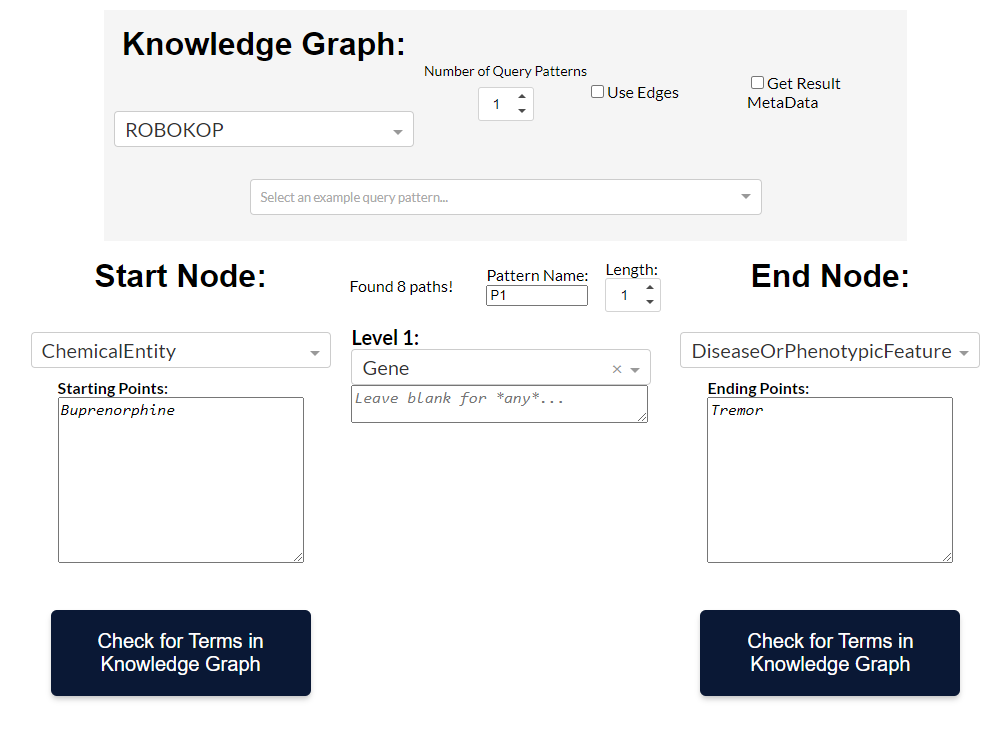

Three rows containing pathways are returned in the image below.

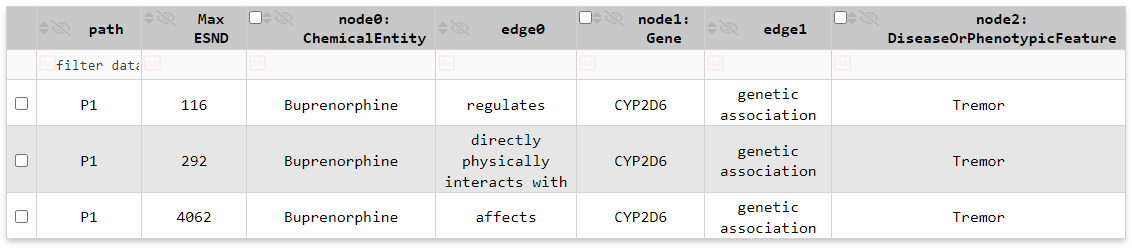

These results are in a collapsed form of the results from queries to `robokopkg.renci.org`, summarized in the code below.  To get an expanded form of the results, check the box "Get Result MetaData" at the top of the ExEmPLAR UI.  This will return 8 results that match with the results from the programmatic results below.

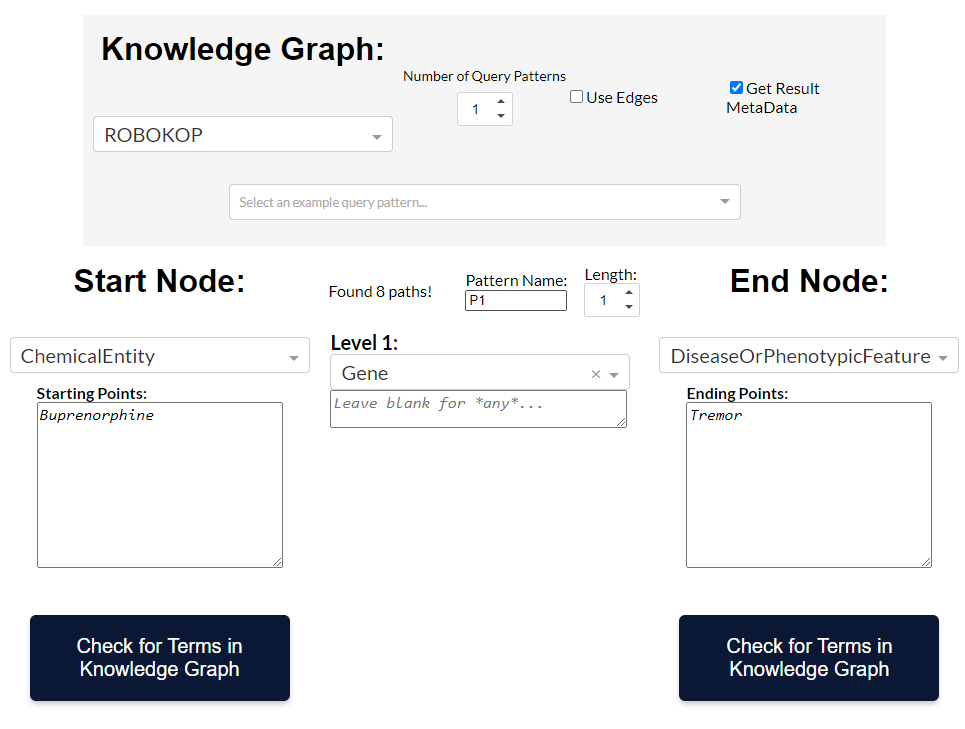

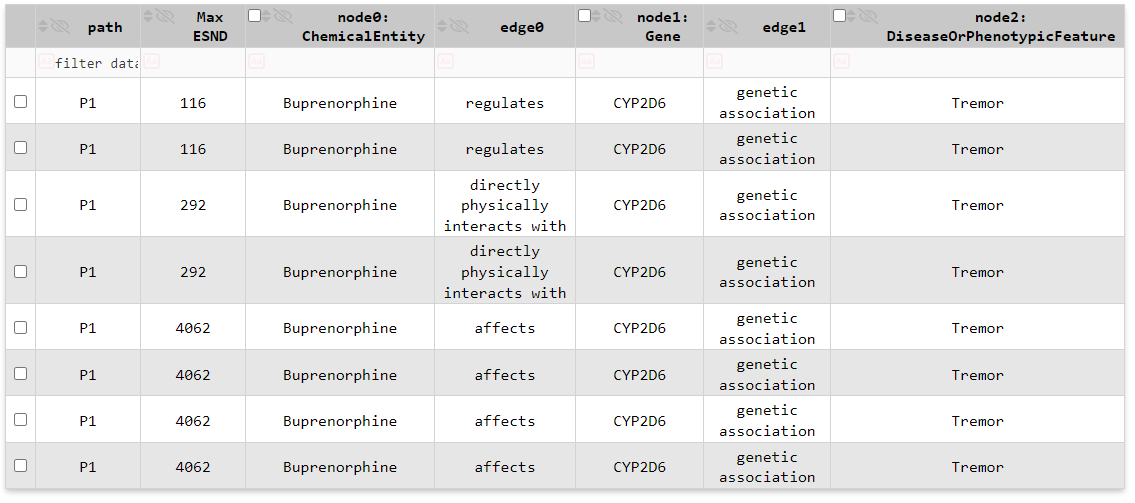

In [2]:
# Buprenorphine -> [Gene] -> Tremor
cypher = f"""MATCH (n0_0:`biolink:ChemicalEntity`)-[r0_0]-(n1_0:`biolink:Gene`)-[r1_0]-(n2_0:`biolink:DiseaseOrPhenotypicFeature`) 
WHERE n0_0.name IN ['Buprenorphine'] AND n2_0.name IN ['Tremor'] 
RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
[startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
[n0_0.name, n1_0.name, n2_0.name] as node_names LIMIT 100"""

from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [3]:
pw = ''
conn = Neo4jConnection(uri="bolt://robokopkg.renci.org:7687", user = 'neo4j', pwd = pw)
record_list = conn.query(cypher)

In [10]:
import os

print("Query to robokopkg.renci.org")

i = 0
for record in record_list:
    i = i + 1
    record_data = record.data()
    
    print(f"Result {i}:")
    for label, data in record_data.items():
        if 'edge' in label:
            print(f"{data[0]['name']} - {data[1][0]} - {data[2]['name']}")
    print()

Query to robokopkg.renci.org
Result 1:
Buprenorphine - biolink:affects - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 2:
CYP2D6 - biolink:affects - Buprenorphine
CYP2D6 - biolink:genetic_association - Tremor

Result 3:
Buprenorphine - biolink:regulates - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 4:
Buprenorphine - biolink:directly_physically_interacts_with - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 5:
Buprenorphine - biolink:affects - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 6:
CYP2D6 - biolink:affects - Buprenorphine
CYP2D6 - biolink:genetic_association - Tremor

Result 7:
Buprenorphine - biolink:regulates - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 8:
Buprenorphine - biolink:directly_physically_interacts_with - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor



## ExEmPLAR - RETURN * notation

ExEmPLAR also has a `Copy` tool that generates cypher queries after setting up a query pattern.  An example using the copied pre-genereated cypher query to each of `automat.renci.org` and `robokopkg.renci.org` is below.  This can be useful for setting up an initial Cypher query if a user is not familiar with writing in Cypher.  More details on querying the ROBOKOP KG using Cypher can be found in `HelloRobokop_RobokopKG.ipynb`.

The difficulty faced with the copied query is that "RETURN \*" is not specific with the structures given back.  In the queries to `automat.renci.org` and `robokopkg.renci.org`, while the nodes and their respective information are preserved, the edges have differing amounts of information returned.  The query to `automat.renci.org` gets most of the edge properties except for the edge predicate and subject/object nodes, thus directionality.  The query to `robokopkg.renci.org` returns the opposite, where the edge predicate is solely returned with no edge properties, which makes the returned information appear redundant.

In [12]:
cypher_exemplar = "MATCH (n0_0:`biolink:ChemicalEntity`)-[r0_0]-(n1_0:`biolink:Gene`)-[r1_0]-(n2_0:`biolink:DiseaseOrPhenotypicFeature`) WHERE n0_0.name IN ['Buprenorphine'] AND n2_0.name IN ['Tremor'] RETURN * LIMIT 100"

In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=5)

In [14]:
import requests
import json

j = {'query': cypher_exemplar}
results = requests.post('https://automat.renci.org/robokopkg/cypher',json=j)
results_json = results.json()

In [15]:
print("Query to automat.renci.org")
i = 0
for result in results_json['results'][0]['data']:
    i = i + 1
    n1 = result['row'][0].get('name') or "NOT FOUND"
    n2 = result['row'][1].get('name') or "NOT FOUND"
    n3 = result['row'][2].get('name') or "NOT FOUND"
    e1 = result['row'][3].get('qualified_predicate') or "NOT FOUND"
    e2 = result['row'][4].get('qualified_predicate') or "NOT FOUND"
    print(f"Result {i}")
    print(f"{n1} -> {e1} -> {n2} -> {e2} -> {n3}")
    print(f"Edge 1 info: {result['row'][3]}")
    print(f"Edge 2 info: {result['row'][4]}\n")
    

Query to automat.renci.org
Result 1
Buprenorphine -> biolink:causes -> CYP2D6 -> NOT FOUND -> Tremor
Edge 1 info: {'object_direction_qualifier': 'decreased', 'qualified_predicate': 'biolink:causes', 'biolink:primary_knowledge_source': 'infores:ctd', 'description': 'decreases activity of', 'NCBITaxon': '9606', 'object_aspect_qualifier': 'activity', 'publications': ['PMID:12756210']}
Edge 2 info: {'score': 0.3, 'biolink:primary_knowledge_source': 'infores:disgenet', 'biolink:aggregator_knowledge_source': ['infores:pharos']}

Result 2
Buprenorphine -> biolink:causes -> CYP2D6 -> NOT FOUND -> Tremor
Edge 1 info: {'object_direction_qualifier': 'increased', 'qualified_predicate': 'biolink:causes', 'biolink:primary_knowledge_source': 'infores:ctd', 'description': 'increases metabolic processing of', 'NCBITaxon': '9606', 'object_aspect_qualifier': 'metabolic_processing', 'publications': ['PMID:12756210']}
Edge 2 info: {'score': 0.3, 'biolink:primary_knowledge_source': 'infores:disgenet', 'biol

In [4]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [16]:
pw = ''
conn = Neo4jConnection(uri="bolt://robokopkg.renci.org:7687", user = 'neo4j', pwd = pw)
record_list = conn.query(cypher_exemplar)

In [17]:
import os

print("Query to robokopkg.renci.org")

i = 0
for record in record_list: 
    i = i + 1
    record_data = record.data()
    
    print(f"Result {i}:")
    for label, data in record_data.items():
        if 'r' in label:
            print(f"{data[0]['name']} - {data[1][0]} - {data[2]['name']}")
    print()

Query to robokopkg.renci.org
Result 1:
Buprenorphine - biolink:affects - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 2:
CYP2D6 - biolink:affects - Buprenorphine
CYP2D6 - biolink:genetic_association - Tremor

Result 3:
Buprenorphine - biolink:regulates - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 4:
Buprenorphine - biolink:directly_physically_interacts_with - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 5:
Buprenorphine - biolink:affects - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 6:
CYP2D6 - biolink:affects - Buprenorphine
CYP2D6 - biolink:genetic_association - Tremor

Result 7:
Buprenorphine - biolink:regulates - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor

Result 8:
Buprenorphine - biolink:directly_physically_interacts_with - CYP2D6
CYP2D6 - biolink:genetic_association - Tremor



To summarize, we encountered issues with using the notation "RETURN \*", mainly because this is not specific with what to return.  Queries to `automat` return edge properties, not including direction or predicates, but queries to `robokopkg.renci.org` return the direction and predicates, not including edge properties.  Above, for `robokopkg.renci.org`, it appears as if results 1 & 5, 2 & 6, 3 & 7, and 4 & 8 are duplicates of each other, while for `automat.renci.org`, edge predicates are missing.  We replaced the "\*" with a format to get node pairs and specific relationship information, including the type and properties.  This is demonstrated in section [Cypher - robokopkg.renci.org](#Cypher---robokopkg.renci.org) in this notebook and in the HelloRobokop_Cypher notebook.